In [ ]:

import pandas as pd
import numpy as np
df=pd.read_csv("/content/FINAL_DATA2.csv")
df.cleanData=df.cleanData.astype(str)

In [ ]:
#df['word_length'] = df['cleanData'].apply(lambda x:len(x.split()))
df.dtypes

twitter_id             int64
content               object
location              object
search_word            int64
word_length            int64
cleanData             object
location_extracted    object
dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(df.cleanData,df.search_word, test_size = 0.2, stratify = df.search_word,random_state = 30)

In [ ]:
from keras.preprocessing.text import Tokenizer
num_words = 10000 # this means 10000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([X_train, X_test], axis = 0)
tokenizer.fit_on_texts(df_total)

In [ ]:
df_total

1168                       hindu religious tradition dest
2250                       injure mumbai slum house crash
858                                       thank keep safe
2390                                         singh victor
1505    today chandigarhtrafficpolice conduct covid am...
                              ...                        
409     two day birthday panchkula major anuj rajput d...
2345    makeroadssafe not government responsibility ev...
678     free amp quality healthcare medicine test oper...
294                                    sir thank feedback
1014    happy birthday city beautiful chandigarh good ...
Name: cleanData, Length: 2462, dtype: object

In [ ]:
len(tokenizer.word_index)

3664

In [ ]:
df.word_length.max()

28

In [ ]:
from keras.preprocessing.sequence import pad_sequences

X_train_ =tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_,maxlen=171,padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = 171, padding = 'post')

In [ ]:
print(X_train_pad.shape,X_test_pad.shape)

(1969, 171) (493, 171)


In [ ]:
import gensim.downloader as api
w2v_gensim  = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
vocabulary = list(w2v_gensim.wv.vocab)
print(vocabulary)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [ ]:
vector_size = 300
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in w2v_gensim.vocab:
            gensim_weight_matrix[index] = w2v_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(300)

In [ ]:
gensim_weight_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08349609,  0.04541016,  0.25      , ..., -0.17773438,
        -0.16113281, -0.01104736],
       [-0.24707031, -0.16015625, -0.06347656, ...,  0.0859375 ,
        -0.1640625 , -0.04101562],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
print(gensim_weight_matrix.shape)
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from keras.models import Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.layers import Dropout

(10000, 300)


In [ ]:
EMBEDDING_DIM = 300 # this means the embedding layer will create  a vector in 100 dimension
model_gensim = Sequential()
model_gensim.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(300,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(400,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(400,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(300,return_sequences=False)))
model_gensim.add(Dense(3, activation = 'softmax'))
model_gensim.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [ ]:
model_gensim.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 171, 300)          3000000   
                                                                 
 dropout (Dropout)           (None, 171, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 171, 600)         1444800   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 171, 600)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 171, 800)         3206400   
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 171, 800)          0

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 8)
mc = ModelCheckpoint('./model_gensim.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
history_gensim = model_gensim.fit(X_train_pad,y_train, epochs = 60, batch_size = 200, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc]  )

Epoch 1/60
10/10 [==============================] - ETA: 0s - loss: 0.5809 - accuracy: 0.8141
Epoch 00001: val_accuracy improved from -inf to 0.92292, saving model to ./model_gensim.h5
10/10 [==============================] - 33s 2s/step - loss: 0.5809 - accuracy: 0.8141 - val_loss: 0.2861 - val_accuracy: 0.9229
Epoch 2/60
10/10 [==============================] - ETA: 0s - loss: 0.2210 - accuracy: 0.9406
Epoch 00002: val_accuracy improved from 0.92292 to 0.92901, saving model to ./model_gensim.h5
10/10 [==============================] - 19s 2s/step - loss: 0.2210 - accuracy: 0.9406 - val_loss: 0.2475 - val_accuracy: 0.9290
Epoch 3/60
10/10 [==============================] - ETA: 0s - loss: 0.1845 - accuracy: 0.9401
Epoch 00003: val_accuracy improved from 0.92901 to 0.94929, saving model to ./model_gensim.h5
10/10 [==============================] - 19s 2s/step - loss: 0.1845 - accuracy: 0.9401 - val_loss: 0.2139 - val_accuracy: 0.9493
Epoch 4/60
10/10 [==============================] - 

In [ ]:
model_gensim.evaluate(X_test_pad, y_test) 

16/16 [==============================] - 3s 205ms/step - loss: 0.2135 - accuracy: 0.9615


[0.21348534524440765, 0.9614604711532593]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

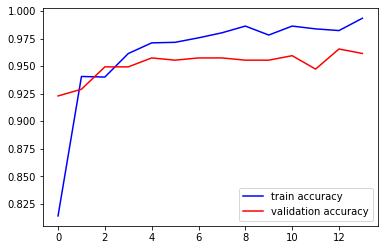

In [ ]:
plt.plot(history_gensim.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_gensim.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
new_complaint = ['There is too much traffic on road which has caused jam from sector 32 to sector 36']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=171,padding='post')
pred = model_gensim.predict(padded)
labels = ['Accident','Traffic','Potholes']
print(pred, labels[np.argmax(pred)])

[[2.9351457e-04 9.9969471e-01 1.1739855e-05]] Traffic


In [ ]:
from sklearn.metrics import classification_report

y_pred=model_gensim.predict(X_test_pad)
predicted = np.argmax(y_pred, axis=1)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.82      0.88        66
           1       0.97      0.99      0.98       418
           2       0.83      0.56      0.67         9

    accuracy                           0.96       493
   macro avg       0.92      0.79      0.84       493
weighted avg       0.96      0.96      0.96       493

